In [31]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta

import torch
import torch.nn as nn

In [32]:
import sys
sys.path.insert(1, '/home/krystian/Repos/XTB-Trader/utility')
sys.path.insert(1, '/home/krystian/Repos/XTB-Trader')
from XTBClient.api import XTBClient, PERIOD
from utility import utility 

def get_data_for_symbol(symbol):
    c = XTBClient()
    c.login(os.environ.get("XTB_user_num"), os.environ.get("XTB_pass"))
    df = c.get_candles_in_range(symbol, PERIOD.FIVE_MINUTES.value, start=datetime.now() - timedelta(days=150))
    c.logout()
    
    df = df.reset_index()
    df.rename(columns={"timestamp": "date"}, inplace=True)
    
    df['date'] = df['date'].apply(pd.to_datetime)
    df.set_index('date',inplace=True)
    return df


# def yf_get_data_for_symbol(symbol):
    # df = utility.collect_yf("EURUSD=x", "1mo", "1h")
    # df = df.reset_index()
    # df.rename(columns={"timestamp": "date"}, inplace=True)
    
    # df['date'] = df['date'].apply(pd.to_datetime)
    # df.set_index('date',inplace=True)
    # return df

In [33]:
df = get_data_for_symbol("EURUSD")
df

,open,close,high,low,volume
date,,,,,
2023-05-23 22:00:00,1.07716,1.07724,1.07730,1.07716,227.0
2023-05-23 22:05:00,1.07724,1.07710,1.07724,1.07700,193.0
2023-05-23 22:10:00,1.07710,1.07706,1.07711,1.07701,407.0
2023-05-23 22:15:00,1.07707,1.07707,1.07714,1.07704,416.0
2023-05-23 22:20:00,1.07708,1.07708,1.07712,1.07706,374.0
...,...,...,...,...,...
2023-06-28 19:30:00,1.09171,1.09177,1.09185,1.09167,2457.0
2023-06-28 19:35:00,1.09178,1.09175,1.09183,1.09173,2123.0
2023-06-28 19:40:00,1.09176,1.09162,1.09177,1.09161,1786.0


In [34]:
closed_prices = df["close"]

In [35]:
seq_len = 15

mm = MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()

In [36]:
X = []
y = []

for i in range(len(scaled_price) - seq_len):
    X.append(scaled_price[i : i + seq_len])
    y.append(scaled_price[i + seq_len])

In [37]:
X = np.array(X)[... , None]
y = np.array(y)[... , None]

In [38]:
train_x = torch.from_numpy(X[:int(0.8 * X.shape[0])]).float()
train_y = torch.from_numpy(y[:int(0.8 * X.shape[0])]).float()
test_x = torch.from_numpy(X[int(0.8 * X.shape[0]):]).float()
test_y = torch.from_numpy(y[int(0.8 * X.shape[0]):]).float()

In [39]:
class Model(nn.Module):
    def __init__(self , input_size , hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size , hidden_size , batch_first = True)
        self.fc = nn.Linear(hidden_size , 1)
    def forward(self , x):
        output , (hidden , cell) = self.lstm(x)
        return self.fc(hidden[-1 , :])
   

In [40]:
model = Model(1 , 64)


optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)
loss_fn = nn.MSELoss()

In [41]:
num_epochs = 100
for epoch in range(num_epochs):
    output = model(train_x)
    loss = loss_fn(output , train_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 and epoch != 0:
        print(epoch , "epoch loss" , loss.detach().numpy())

10 epoch loss 0.12922347
20 epoch loss 0.039030842
30 epoch loss 0.034410037
40 epoch loss 0.030731304
50 epoch loss 0.02241156
60 epoch loss 0.01118499
70 epoch loss 0.0016935645
80 epoch loss 0.0023673486
90 epoch loss 0.0011669132


In [42]:
model.eval()
with torch.no_grad():
    output = model(test_x)

pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_y.numpy())
index = df[int(0.8*len(df)+3):].index

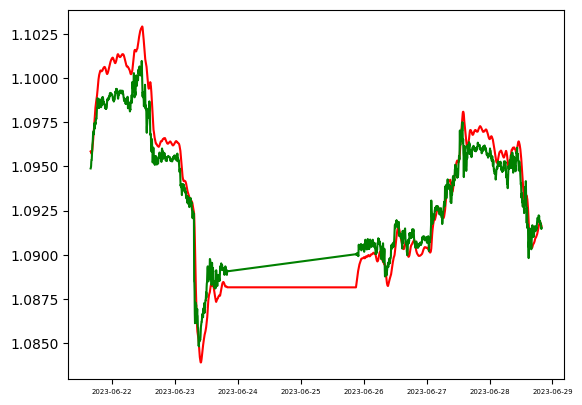

In [43]:
plt.plot(index, pred.squeeze() , color = "red" , label = "predicted")
plt.plot(index, real.squeeze() , color = "green" , label = "real")
plt.xticks(fontsize=5)
plt.show()

In [44]:
torch.save(model, "lstm_model")

In [45]:
trained_till = df[:train_x.shape[0]].index.max()

In [46]:
print("Model trained using data to: " + str(trained_till))

Model trained using data to: 2023-06-21 14:25:00


# Evaluation

In [47]:
df = get_data_for_symbol("EURUSD")

In [48]:
df = df[df.index > trained_till]

In [49]:
df

,open,close,high,low,volume
date,,,,,
2023-06-21 14:30:00,1.09443,1.09478,1.09485,1.09439,8045.0
2023-06-21 14:35:00,1.09478,1.09558,1.09583,1.09472,7364.0
2023-06-21 14:40:00,1.09557,1.09587,1.09637,1.09557,7362.0
2023-06-21 14:45:00,1.09587,1.09585,1.09592,1.09545,7119.0
2023-06-21 14:50:00,1.09584,1.09548,1.09587,1.09518,6907.0
...,...,...,...,...,...
2023-06-28 19:30:00,1.09171,1.09177,1.09185,1.09167,2457.0
2023-06-28 19:35:00,1.09178,1.09175,1.09183,1.09173,2123.0
2023-06-28 19:40:00,1.09176,1.09162,1.09177,1.09161,1786.0


In [50]:
model = torch.load("lstm_model")

In [51]:
model.eval()

Model(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [52]:
closed_prices = df["close"]

In [53]:
seq_len = 15

mm = MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()

In [54]:
X = []
y = []

for i in range(len(scaled_price) - seq_len):
    X.append(scaled_price[i : i + seq_len])
    y.append(scaled_price[i + seq_len])

In [55]:
X = np.array(X)[... , None]
y = np.array(y)[... , None]

In [56]:
test_x = torch.from_numpy(X).float()
test_y = torch.from_numpy(y).float()

In [57]:
model.eval()
with torch.no_grad():
    output = model(test_x)

pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_y.numpy())
index = df.head(real.shape[0]).index

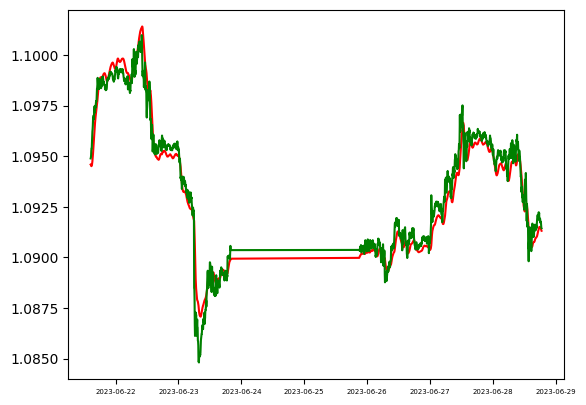

In [58]:
plt.plot(index, pred.squeeze() , color = "red" , label = "predicted")
plt.plot(index, real.squeeze() , color = "green" , label = "real")
plt.xticks(fontsize=5)
plt.show()